In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# text cleaning
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud


# data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import RandomOverSampler

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from collections import Counter
from gensim.models import Word2Vec

import random
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [153]:
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv('CNN_Articels_clean.csv')

In [154]:
df.head()

,Date published,Category,Section,Article
0,7/15/21 2:46,news,world,"There's a shortage of truckers, but TuSimple t..."
1,5/12/21 7:52,news,world,Bioservo's robotic 'Ironhand' could protect fa...
2,6/16/21 2:51,news,asia,This swarm of robots gets smarter the more it ...
3,3/15/22 9:57,business,investing,Russia is no longer an option for investors. T...
4,3/15/22 11:27,business,business,Russian energy investment ban part of new EU s...


In [155]:
new_df = df[['Category', 'Article']]

In [156]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4076 entries, 0 to 4075
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  4076 non-null   object
 1   Article   4076 non-null   object
dtypes: object(2)
memory usage: 63.8+ KB


In [157]:
new_df.duplicated().sum()

0

In [158]:
new_df.Category.value_counts()

sport            2176
news             1611
business          104
politics           75
entertainment      58
health             52
Name: Category, dtype: int64

In [31]:
for i in range (5):
    print(new_df.Article[i])
    print("========================================")

There's a shortage of truckers, but TuSimple thinks it has a solution: no driver needed - CNN The e-commerce boom has exacerbated a global truck driver shortage, but could autonomous trucks help fix the problem? world, There's a shortage of truckers, but TuSimple thinks it has a solution: no driver needed - CNN There's a shortage of truckers, but TuSimple thinks it has a solution: no driver needed  (CNN)Right now, there's a shortage of truck drivers in the US and worldwide, exacerbated by the e-commerce boom brought on by the pandemic. One solution to the problem is autonomous trucks, and several companies are in a race to be the first to launch one. Among them is San Diego-based TuSimple.Founded in 2015, TuSimple has completed about 2 million miles of road tests with its 70 prototype trucks across the US, China and Europe. Although these are simply commercially available trucks retrofitted with its technology, TuSimple has deals in place with two of the world's largest truck manufactu

In [159]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [162]:
stop_word = set(stopwords.words('english'))
my_list = set(['say','said','caption','photo','hide'])

**Text Cleaning**

In [164]:
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if (word.lower() not in stop_word) and (word.lower() not in my_list))
    return text

def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) or ('-' in word) or ('#' in word) else word for word in text.split())

def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def lemmatize(text):
    words = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

def clean_text(text):
    text = strip_all_entities(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = remove_numbers(text)
    text = lemmatize(text)
    text = remove_short_words(text)
    text = ' '.join(text.split())
    return text

In [165]:
new_df['Article_clean'] = [clean_text(text) for text in new_df['Article']]

<ipython-input-165-27a0bfd087ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Article_clean'] = [clean_text(text) for text in new_df['Article']]


In [166]:
new_df['text_len'] = [len(text.split()) for text in new_df.Article_clean]

In [167]:
new_df.sort_values(by=['text_len'], ascending=False)

,Category,Article,Article_clean,text_len
166,politics,Key dates for the 2022 midterm election - CNNP...,key date midterm election cnnpolitics voting e...,3268
667,health,Heroin in America: The scarring of the next ge...,heroin america scarring next generation cnn he...,3118
574,news,"Aid workers in ISIS bull's-eye: 'If not us, th...",aid worker isi bullseye cnn aid worker front l...,3112
640,news,A gunman killed his brother. Now Farris Baraka...,gunman killed brother farris barakat american ...,3087
599,news,Beyond the border: Life in limbo - CNN Jesús a...,beyond border life limbo cnn jesús mother thou...,3058
...,...,...,...,...
3869,sport,The Ashes: Australia beat England by 275 runs ...,ash australia beat england run adelaide test c...,87
3564,news,Paris fire: Blaze near Place de L'Opera in Fre...,paris fire blaze near place de lopera french c...,85
460,news,How to provide aid to those in Ukraine - CNN R...,provide aid ukraine cnn russian bombardment fi...,80
2694,sport,These African athletes made history at Tokyo 2...,african athlete made history tokyo cnn kenya e...,72


In [168]:
max_len = np.max(new_df['text_len'])

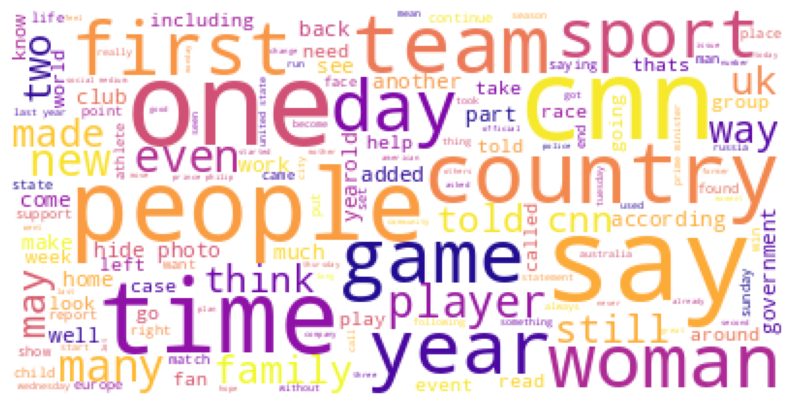

In [172]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=60, figure_size=(10,6),
                   title = None, title_size=40, image_color=False):
    plt.figure(figsize=figure_size)
    if mask is not None:
        wc = WordCloud(background_color="white", max_words=max_words, max_font_size=max_font_size, mask=mask)
    else:
        wc = WordCloud(background_color="white", max_words=max_words, max_font_size=max_font_size)
    wc.generate(text)
    plt.title(title, fontsize=title_size)
    plt.imshow(wc.recolor(colormap='plasma', random_state=17), alpha=0.98)
    plt.axis('off')
    plt.show()
text = ' '.join(new_df['Article_clean'])
plot_wordcloud(text)

Category column encoding

In [173]:
categories = ['sport', 'news', 'business', 'politics', 'entertainment', 'health']
new_df['Category'] = new_df['Category'].replace({'sport':0, 'news':1, 'business':2, 'politics':3,'entertainment':4, 'health':5})
new_df.head()

,Category,Article,Article_clean,text_len
0,1,"There's a shortage of truckers, but TuSimple t...",there shortage trucker tusimple think solution...,1169
1,1,Bioservo's robotic 'Ironhand' could protect fa...,bioservos robotic ironhand could protect facto...,569
2,1,This swarm of robots gets smarter the more it ...,swarm robot get smarter work cnn hong kong war...,351
3,2,Russia is no longer an option for investors. T...,russia longer option investor emerging market ...,345
4,2,Russian energy investment ban part of new EU s...,russian energy investment ban part new eu sanc...,359


In [174]:
# Train_test_split
X = new_df['Article_clean']
y = new_df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [175]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1740],
       [   1, 1289],
       [   2,   83],
       [   3,   60],
       [   4,   46],
       [   5,   42]])

In [176]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['Article_clean', 'Category'])

In [177]:
X_train = train_os['Article_clean'].values
y_train = train_os['Category'].values

(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1740],
       [   1, 1740],
       [   2, 1740],
       [   3, 1740],
       [   4, 1740],
       [   5, 1740]])

Trigram / Bigram

In [82]:
def generate_N_grams(text,ngram=1):
  words=[word for word in text.split(" ")]
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

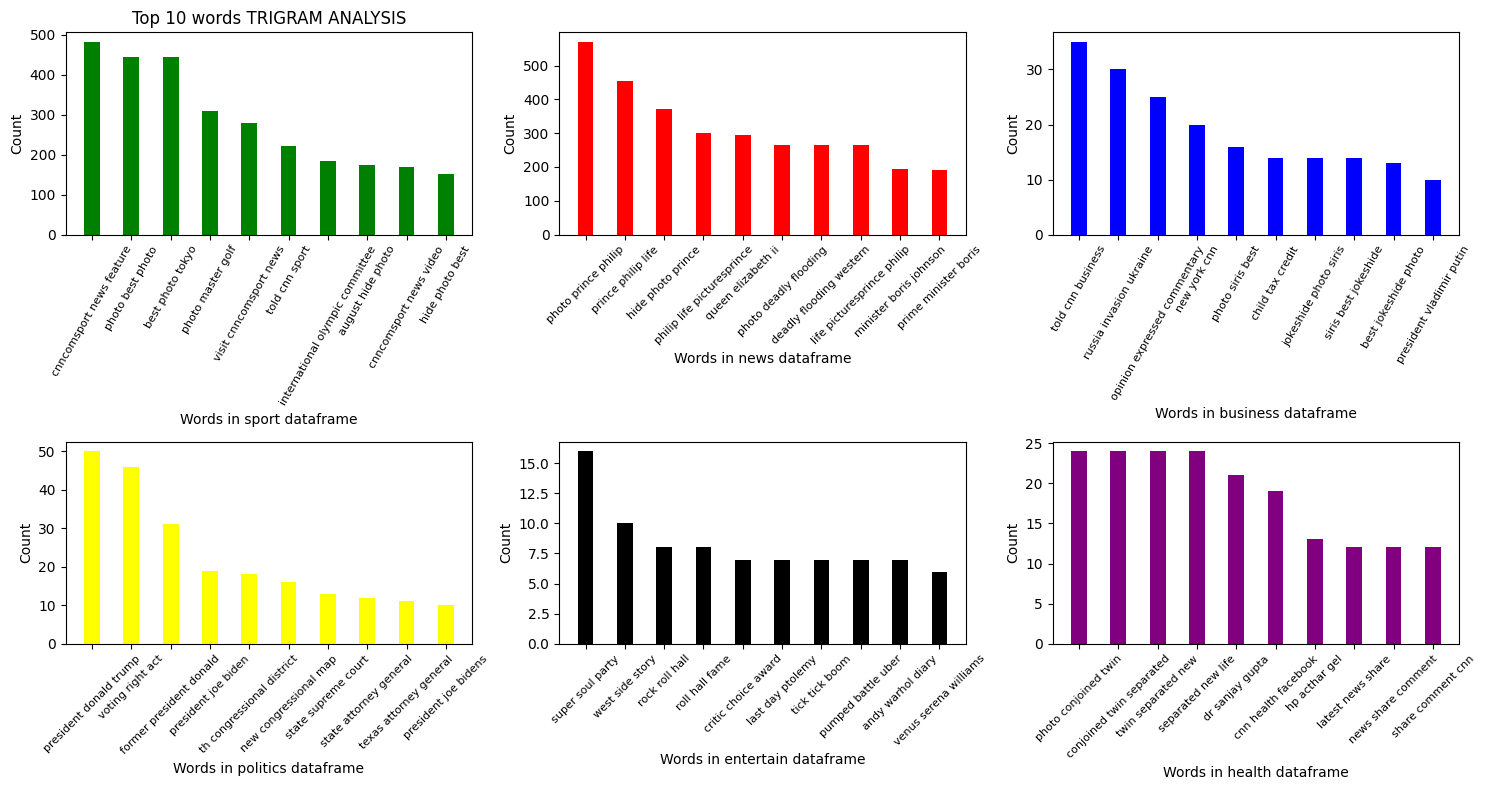

In [151]:
from collections import defaultdict
sportvalue=defaultdict(int)
newsvalue=defaultdict(int)
businessvalue=defaultdict(int)
politicsvalue=defaultdict(int)
entertainmentvalue=defaultdict(int)
healthvalue=defaultdict(int)

#get the count of every word in both the columns of df_train and df_test dataframes where sentiment="positive"
for text in new_df[new_df.Category==0].Article_clean:
  for word in generate_N_grams(text,3):
    sportvalue[word]+=1

for text in new_df[new_df.Category==1].Article_clean:
  for word in generate_N_grams(text,3):
    newsvalue[word]+=1

for text in new_df[new_df.Category==2].Article_clean:
  for word in generate_N_grams(text,3):
    businessvalue[word]+=1

for text in new_df[new_df.Category==3].Article_clean:
  for word in generate_N_grams(text,3):
    politicsvalue[word]+=1

for text in new_df[new_df.Category==4].Article_clean:
  for word in generate_N_grams(text,3):
    entertainmentvalue[word]+=1

for text in new_df[new_df.Category==5].Article_clean:
  for word in generate_N_grams(text,3):
    healthvalue[word]+=1


df_sport=pd.DataFrame(sorted(sportvalue.items(),key=lambda x:x[1],reverse=True))
df_news=pd.DataFrame(sorted(newsvalue.items(),key=lambda x:x[1],reverse=True))
df_business=pd.DataFrame(sorted(businessvalue.items(),key=lambda x:x[1],reverse=True))
df_politics=pd.DataFrame(sorted(politicsvalue.items(),key=lambda x:x[1],reverse=True))
df_entertainment=pd.DataFrame(sorted(entertainmentvalue.items(),key=lambda x:x[1],reverse=True))
df_health=pd.DataFrame(sorted(healthvalue.items(),key=lambda x:x[1],reverse=True))

sporttri_x=df_sport[0][:10]
sprottri_y=df_sport[1][:10]

newstri_x=df_news[0][:10]
newstri_y=df_news[1][:10]

businesstri_x=df_business[0][:10]
businesstri_y=df_business[1][:10]

politicstri_x=df_politics[0][:10]
politicstri_y=df_politics[1][:10]

entertainstri_x=df_entertainment[0][:10]
entertainstri_y=df_entertainment[1][:10]

healthtri_x=df_health[0][:10]
healthtri_y=df_health[1][:10]

plt.figure(1,figsize=(15,8))
plt.subplot(231)
plt.bar(sporttri_x,sprottri_y, color ='green',
        width = 0.4)
plt.xticks(rotation=60, size =8)
plt.xlabel("Words in sport dataframe")
plt.ylabel("Count")
plt.title("Top 10 words TRIGRAM ANALYSIS")


plt.subplot(232)
plt.figure(1,figsize=(15,8))
plt.bar(newstri_x,newstri_y, color ='red',
        width = 0.4)
plt.xticks(rotation=45, size=8)
plt.xlabel("Words in news dataframe")
plt.ylabel("Count")

plt.subplot(233)
plt.figure(1,figsize=(15,8))
plt.bar(businesstri_x,businesstri_y, color ='blue',
        width = 0.4)
plt.xticks(rotation=60,size=8)
plt.xlabel("Words in business dataframe")
plt.ylabel("Count")

plt.subplot(234)
plt.figure(1,figsize=(15,8))
plt.bar(politicstri_x,politicstri_y, color ='yellow',
        width = 0.4)
plt.xticks(rotation=45, size=8)
plt.xlabel("Words in politics dataframe")
plt.ylabel("Count")

plt.subplot(235)
plt.figure(1,figsize=(15,8))
plt.bar(entertainstri_x,entertainstri_y, color ='black',
        width = 0.4)
plt.xticks(rotation=45, size=8)
plt.xlabel("Words in entertain dataframe")
plt.ylabel("Count")

plt.subplot(236)
plt.figure(1,figsize=(15,8))
plt.bar(healthtri_x,healthtri_y, color ='purple',
        width = 0.4)
plt.xticks(rotation=45, size=8)
plt.xlabel("Words in health dataframe")
plt.ylabel("Count")


plt.tight_layout()
plt.show()

Naive Bayes baseline model

In [178]:
clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [179]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train)
nb_pred = nb_clf.predict(X_test_tf)

In [180]:
print(classification_report(y_test, nb_pred, target_names=categories))

               precision    recall  f1-score   support

        sport       1.00      0.95      0.97       436
         news       0.96      0.83      0.89       322
     business       0.55      0.86      0.67        21
     politics       0.71      1.00      0.83        15
entertainment       0.86      0.50      0.63        12
       health       0.16      1.00      0.28        10

     accuracy                           0.89       816
    macro avg       0.71      0.86      0.71       816
 weighted avg       0.95      0.89      0.92       816



In [185]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(6,6))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=17)
    ax.xaxis.set_ticklabels(labels, fontsize=12,rotation=45)
    ax.yaxis.set_ticklabels(labels, fontsize=12 ,rotation=45)
    ax.set_ylabel('Test', fontsize=17)
    ax.set_xlabel('Predicted', fontsize=17)
    plt.show()

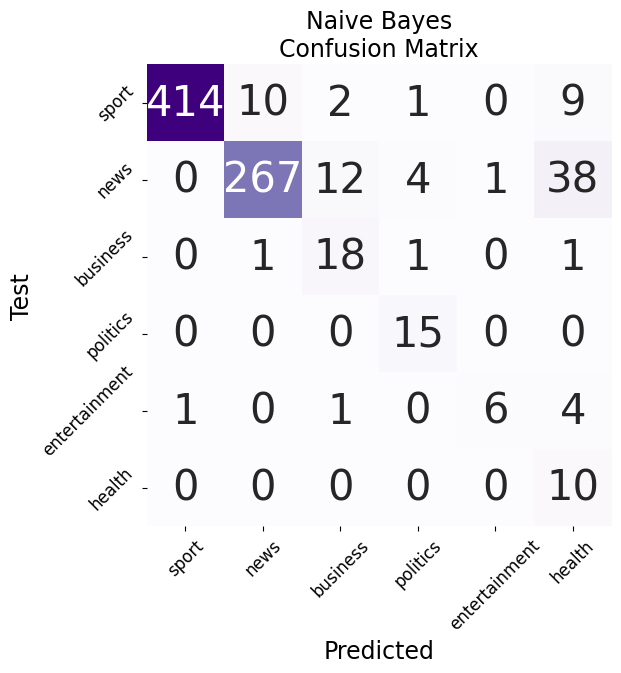

In [186]:
conf_matrix(y_test,nb_pred,'Naive Bayes\nConfusion Matrix', categories)

LSTM RNN

In [187]:
def Tokenize(column, seq_len):
  corpus = [word for text in column for word in text.split()]
  count_words = Counter(corpus)
  sorted_words = count_words.most_common()
  vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

  # tokenize columns text
  text_int = []
  for text in column:
    r = [vocab_to_int[word] for word in text.split()]
    text_int.append(r)

  # add padding
  features = np.zeros((len(text_int), seq_len), dtype=int)
  for i, review in enumerate(text_int):
    if len(review) <= seq_len:
      zeros = list(np.zeros(seq_len - len(review)))
      new = zeros + review
    else:
      new = review[:seq_len]
    features[i, :] = np.array(new)

  return sorted_words, features

In [188]:
vocabulary, tokenized_text = Tokenize(new_df['Article_clean'], max_len)

In [189]:
new_df['Article_clean'].iloc[321]

'here gold medal beijing olympics sunday cnn five gold medal grab sunday beijing winter olympics sport here gold medal beijing olympics sunday cnn here gold medal beijing olympics sunday cnnthere five gold medal grab sunday beijing winter olympicsheres breakdown took home gold delegation day gamesalpine skiingmixed team parallel big austriabobsleighman francesco friedrich germanyread morecrosscountry skiingwomens km mass start free therese johaug norwaycurlingwomens great britainice hockeymens finlandthe full medal table found'

In [190]:
tokenized_text[321]

array([   0,    0,    0, ...,  219, 1335,  139])

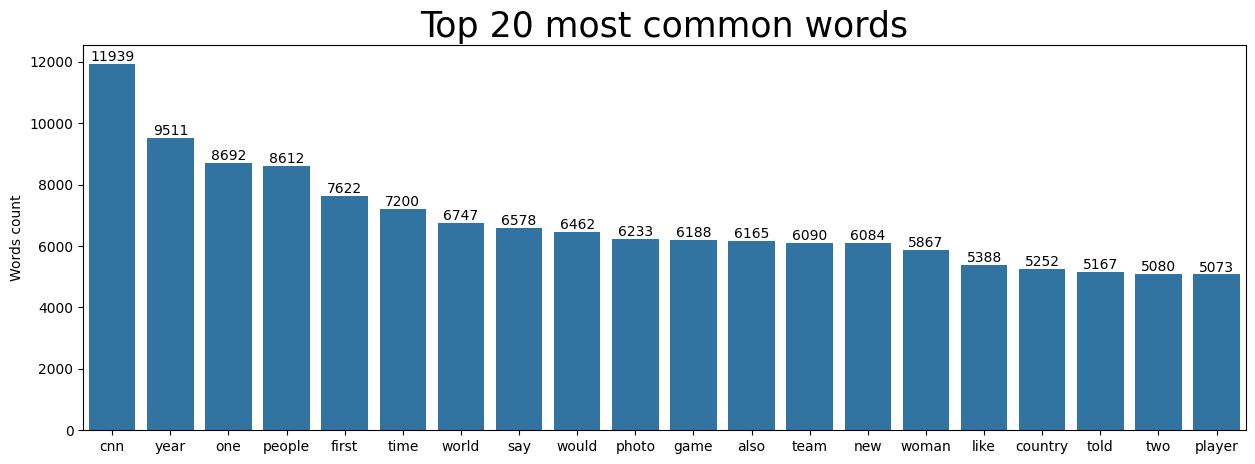

In [191]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=keys, y=values)
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

Word Embedding

In [192]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

Embedding_dim = 300

Word2Vec_model = Word2Vec(Word2vec_train_data, vector_size=Embedding_dim)

Vocab_size = len(vocabulary) + 1
print('vocab size', Vocab_size)

# initialize matrix
embedding_matrix = np.zeros((Vocab_size, Embedding_dim))

# fill matrix with pre trained value from word2vec
for word, token in vocabulary:
  if word in Word2Vec_model.wv.key_to_index:
    embedding_vector = Word2Vec_model.wv[word]
    embedding_matrix[token] = embedding_vector
print(embedding_matrix.shape)

vocab size 117111
(117111, 300)


Train-validation-test

In [193]:
X = tokenized_text
y = new_df['Category'].values

print(X)
print(y)

[[    0     0     0 ...   358    28  9796]
 [    0     0     0 ...   791 11752   429]
 [    0     0     0 ...    98   492   186]
 ...
 [    0     0     0 ...   375   798   692]
 [    0     0     0 ...  2457   253  1177]
 [    0     0     0 ...   541 15865 11795]]
[1 1 1 ... 0 1 0]


In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [195]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1392],
       [   1, 1031],
       [   2,   66],
       [   3,   48],
       [   4,   37],
       [   5,   34]])

In [196]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train), np.array(y_train))

In [197]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1392],
       [   1, 1392],
       [   2, 1392],
       [   3, 1392],
       [   4, 1392],
       [   5, 1392]])

Dataset, DataLoader

In [198]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

BATCH_SIZE = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE,drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE,drop_last=True)

Model

In [200]:
class LSTM(nn.Module):
  def __init__(self,vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
    super(LSTM,self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = lstm_layers
    self.is_bidirectional = is_bidirectional

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
    self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
    self.softmax = nn.LogSoftmax(dim=1)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, hidden):
    embedded = self.embedding(x)
    out, hidden = self.lstm(embedded, hidden)
    out = self.dropout(out)
    out = self.fc(out[:, -1, :])
    out = self.softmax(out)
    return out, hidden

  def init_hidden(self, batch_size):
    factor = 2 if self.is_bidirectional else 1
    h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
    c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)

In [201]:
NUM_CLASSES = 5
HIDDEN_DIM = 128
LSTM_LAYERS = 1
IS_BIDIRECTIONAL = True
DROPOUT = 0.5
LR = 1e-4
EPOCHS = 30
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM(Vocab_size, Embedding_dim, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT,IS_BIDIRECTIONAL)
model = model.to(DEVICE)

model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
model.embedding.weight.requires_grad = True

criterion = nn.NLLLoss(ignore_index=5)
optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay = 1e-5)

print(model)

LSTM(
  (embedding): Embedding(117111, 300)
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [202]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0
valid_acc_max = 0

for e in range(EPOCHS):

    train_loss, valid_loss  = [], []
    train_acc, valid_acc  = [], []
    y_train_list, y_val_list = [], []

    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0

    # Training
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        h = model.init_hidden(labels.size(0))
        model.zero_grad()
        output, h = model(inputs,h)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1)
        y_train_list.extend(y_pred_train.squeeze().tolist())
        correct += torch.sum(y_pred_train==labels).item()
        total += labels.size(0)
    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    # validation

    with torch.no_grad():
        model.eval()
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            val_h = model.init_hidden(labels.size(0))
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()
            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())
            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1

    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break

    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 28.906250).  Saving model
	Train_loss : 1.5614 Val_loss : 1.5640
	Train_acc : 26.911% Val_acc : 28.906%
Epoch 2:Validation accuracy did not increase
	Train_loss : 1.4459 Val_loss : 1.5399
	Train_acc : 45.349% Val_acc : 23.750%
Epoch 3:Validation accuracy did not increase
	Train_loss : 1.1213 Val_loss : 1.4511
	Train_acc : 51.034% Val_acc : 17.344%
Epoch 4:Validation accuracy increased (28.906250 --> 54.687500).  Saving model
	Train_loss : 0.7014 Val_loss : 1.1378
	Train_acc : 60.385% Val_acc : 54.688%
Epoch 5:Validation accuracy increased (54.687500 --> 59.843750).  Saving model
	Train_loss : 0.4831 Val_loss : 0.9336
	Train_acc : 67.524% Val_acc : 59.844%
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.3665 Val_loss : 0.8773
	Train_acc : 69.363% Val_acc : 59.688%
Epoch 7:Validation accuracy increased (59.843750 --> 60.000000).  Saving model
	Train_loss : 0.3435 Val_loss : 0.8541
	Train_acc : 70.204% Val_acc : 60.000%
Epoc

In [203]:
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [204]:
def evaluate_model(model, test_loader):
  model.eval()
  y_pred_list = []
  y_test_list = []

  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(Device), labels.to(Device)
      test_h = model.init_hidden(labels.size(0))

      output, val_h = model(inputs, test_h)

      y_pred_test = torch.argmax(output, dim=1)
      y_pred_list.extend(y_pred_test.squeeze().tolist())
      y_test_list.extend(labels.squeeze().tolist())
  return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

In [205]:
print(classification_report(y_test_list, y_pred_list, target_names=categories))

               precision    recall  f1-score   support

        sport       0.85      0.95      0.90       405
         news       0.87      0.84      0.85       307
     business       0.80      0.38      0.52        21
     politics       0.56      0.36      0.43        14
entertainment       0.67      0.18      0.29        11
       health       0.00      0.00      0.00        10

     accuracy                           0.85       768
    macro avg       0.62      0.45      0.50       768
 weighted avg       0.84      0.85      0.84       768



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


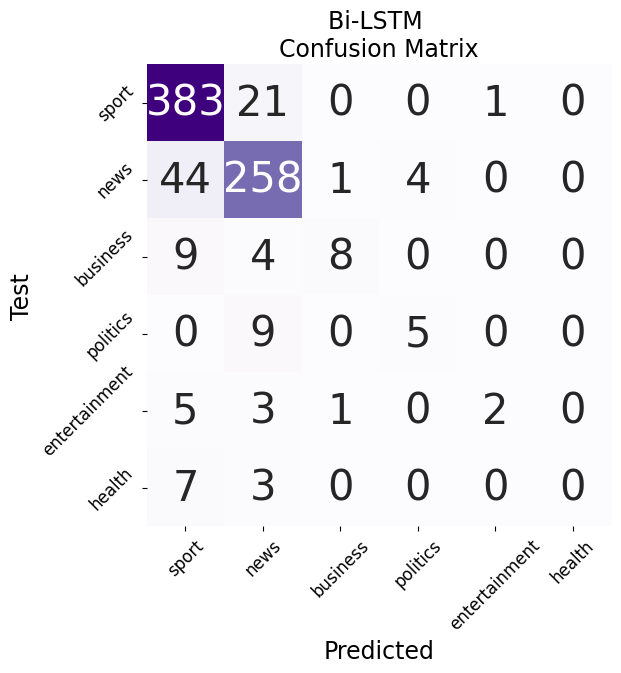

In [206]:
conf_matrix(y_test_list,y_pred_list,'Bi-LSTM \nConfusion Matrix', categories)